In [1]:
%load_ext autoreload

In [2]:
%autoreload
import pygmsh
import numpy as np
import jax.numpy as jnp
from dctkit.mesh import util, simplex
from dctkit.math.opt import optctrl
from dctkit.physics.elasticity import LinearElasticity
import dctkit.dec.cochain as C
import dctkit as dt
from matplotlib.pyplot import triplot
from functools import partial

In [3]:
dt.config()

In [4]:
lc = 0.2
L = 1.
with pygmsh.geo.Geometry() as geom:
    p = geom.add_polygon([[0., 0.], [L, 0.], [L, L], [0., L]], mesh_size=lc)
    # create a default physical group for the boundary lines
    geom.add_physical(p.lines, label="boundary")
    geom.add_physical(p.lines[0], label="down")
    geom.add_physical(p.lines[2], label="up")
    geom.add_physical(p.lines[1], label="right")
    geom.add_physical(p.lines[3], label="left")
    mesh = geom.generate_mesh()

S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()
S.get_flat_DPD_weights()
S.get_flat_DPP_weights()

ref_node_coords = S.node_coords

In [5]:
down_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "down")
up_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "up")
down_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "down")
up_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "up")
left_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "left")
right_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "right")
left_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "left")
right_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "right")

print(down_bnd_edges_idx)
print(up_bnd_edges_idx)

[0, 12, 15, 18, 3]
[7, 34, 37, 40, 9]


In [27]:
mu_ = 1.
lambda_ = 10.
gamma_ = 0.2
tau_ = mu_*gamma_
true_curr_node_coords = S.node_coords.copy()
true_curr_node_coords[:, 0] += gamma_*S.node_coords[:, 1]
up_bnd_pos_components = [0]

up_bnd_nodes_pos_x = true_curr_node_coords[up_bnd_nodes_idx, up_bnd_pos_components]
up_bnd_nodes_pos_y = ref_node_coords[up_bnd_nodes_idx, 1]
down_bnd_pos = ref_node_coords[down_bnd_nodes_idx, :]

In [28]:
# NOTE: without flatten it does not work properly when concatenating multiple bcs;
# fix this so that flatten is not needed (not intuitive)
boundary_values = {"0": (up_bnd_nodes_idx, up_bnd_nodes_pos_x),
                   ":": (down_bnd_nodes_idx, down_bnd_pos)}
ela = LinearElasticity(S=S, mu_=mu_, lambda_=lambda_)
gamma = 100000.
num_faces = S.S[2].shape[0]
embedded_dim = S.space_dim
f = np.zeros((num_faces, (embedded_dim-1)))
#f = np.zeros((S.num_nodes, (embedded_dim-1)), dtype=dt.float_dtype)
curr_node_coords = jnp.full(
    S.node_coords.shape, jnp.nan, dtype=dt.float_dtype)
#obj = ela.obj_linear_elasticity_energy
obj = ela.obj_linear_elasticity_primal
x0 = S.node_coords.flatten()
# x0 = true_curr_node_coords.flatten()

#unknown_node_coords = S.node_coords.copy()
#unknown_node_coords[up_bnd_nodes_idx , 0] = np.nan
#unknown_node_coords[down_bnd_nodes_idx, :] = np.nan
#unknown_node_coords_flattened = unknown_node_coords.flatten()
#unknown_node_idx = ~np.isnan(unknown_node_coords_flattened)
#x0 = unknown_node_coords_flattened[unknown_node_idx]
#obj = partial(ela.obj_linear_elasticity_dual,
#                          unknown_node_idx=unknown_node_idx)


# traction bcs
primal_vol_left = S.primal_volumes[1][left_bnd_edges_idx]
primal_vol_right = S.primal_volumes[1][right_bnd_edges_idx]
idx_left_right_edges = left_bnd_edges_idx + right_bnd_edges_idx
bnd_tractions_up = np.zeros(len(up_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_left = tau_*np.ones(len(left_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_left *= primal_vol_left
bnd_tractions_right = -tau_*np.ones(len(right_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_right *= primal_vol_right
bnd_tractions_left_right = np.zeros(len(idx_left_right_edges), dtype = dt.float_dtype)
idx_tract_y = up_bnd_edges_idx + idx_left_right_edges
bnd_tractions_y = np.concatenate((bnd_tractions_up, bnd_tractions_left, bnd_tractions_right))

boundary_tractions = {'1': (idx_tract_y, bnd_tractions_y),
                     '0': (idx_left_right_edges, bnd_tractions_left_right)}
#obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values}
#obj_args = {'f': f,
#            'boundary_values': boundary_values,
#            'boundary_tractions': boundary_tractions,
#            'curr_node_coords': curr_node_coords}
obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values, 'boundary_tractions': boundary_tractions}

In [29]:
prb = optctrl.OptimizationProblem(dim=len(x0), state_dim=len(x0),objfun=obj)

prb.set_obj_args(obj_args)
sol = prb.solve(x0=x0, ftol_abs=1e-9, ftol_rel=1e-9, maxeval = 10000)
print(prb.last_opt_result)
curr_node_coords = sol.reshape(S.node_coords.shape)
#print(len(sol))
#curr_node_coords = ela.set_displacement_bc(curr_node_coords, boundary_values)
#curr_node_coords_flattened = curr_node_coords.flatten()
#curr_node_coords_flattened = curr_node_coords_flattened.at[jnp.isnan(
#    curr_node_coords_flattened)].set(sol)
#curr_node_coords = curr_node_coords_flattened.reshape(S.node_coords.shape)

3


In [34]:
#print(obj(sol, f, gamma, boundary_values, boundary_tractions))
#print(obj(true_curr_node_coords.flatten(), f, gamma, boundary_values, boundary_tractions))
true_node_coch = C.CochainP0(S, true_curr_node_coords)
f_coch = C.CochainP2(S, f)
res = ela.force_balance_residual_primal(true_node_coch, f_coch, boundary_tractions)
bad_coeffs =np.where(res.coeffs[:,1] > 1e-8)
print(bad_coeffs)

(array([11, 17, 25, 36]),)


In [35]:
bad_cells = S.S[2][bad_coeffs, :]
print(bad_cells)
print(S.node_coords[bad_cells])

[[[17 18 20]
  [18 19 30]
  [16 17 31]
  [ 3 16 38]]]
[[[[0.         0.6        0.        ]
   [0.         0.4        0.        ]
   [0.16370661 0.48866509 0.        ]]

  [[0.         0.4        0.        ]
   [0.         0.2        0.        ]
   [0.16938214 0.30011358 0.        ]]

  [[0.         0.8        0.        ]
   [0.         0.6        0.        ]
   [0.1881897  0.68364149 0.        ]]

  [[0.         1.         0.        ]
   [0.         0.8        0.        ]
   [0.14641016 0.85358984 0.        ]]]]


In [31]:
strain = ela.get_infinitesimal_strain(curr_node_coords)
stress = ela.get_stress(strain)

print("strain=", strain)
print("stress=", stress)

strain= [[[ 4.26189783e-02  6.67766969e-02]
  [ 6.67766969e-02 -5.05209888e-02]]

 [[-6.24676652e-03  4.70474403e-02]
  [ 4.70474403e-02 -5.77028522e-03]]

 [[-3.00099101e-03  5.99178537e-02]
  [ 5.99178537e-02  2.99007704e-03]]

 [[-4.42324537e-02  6.01433418e-02]
  [ 6.01433418e-02  5.56405287e-02]]

 [[ 1.78245035e-02  7.68101675e-02]
  [ 7.68101675e-02 -1.55210268e-02]]

 [[-5.90795318e-02  6.26498513e-02]
  [ 6.26498513e-02  5.55107020e-02]]

 [[ 5.44119518e-02  5.52703142e-02]
  [ 5.52703142e-02 -5.24809624e-02]]

 [[-2.81680458e-03  6.14821627e-02]
  [ 6.14821627e-02  5.58161610e-03]]

 [[ 1.80599353e-02  7.50954182e-02]
  [ 7.50954182e-02 -1.98549927e-02]]

 [[ 6.56995486e-02  7.33061293e-04]
  [ 7.33061293e-04 -7.98813856e-02]]

 [[ 4.59463818e-06  7.39857183e-02]
  [ 7.39857183e-02  1.00114282e-03]]

 [[-7.82628718e-02  8.52499785e-03]
  [ 8.52499785e-03  9.96667792e-02]]

 [[ 3.05509199e-03  8.92471274e-02]
  [ 8.92471274e-02 -6.01320108e-03]]

 [[ 1.40569945e-06  1.39439724

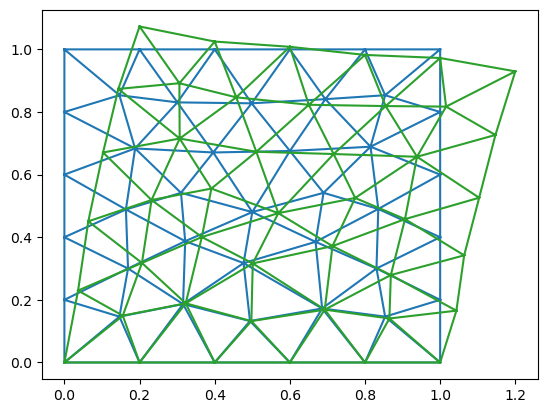

In [11]:
triplot(ref_node_coords[:,0], ref_node_coords[:,1], triangles=S.S[2])
triplot(curr_node_coords[:,0], curr_node_coords[:,1], triangles=S.S[2])

In [12]:
print(ela.obj_linear_elasticity_energy(curr_node_coords, f, gamma, boundary_values))
print(ela.obj_linear_elasticity_energy(true_curr_node_coords, f, gamma, boundary_values))
node_coords_coch = C.CochainP0(complex=S, coeffs=curr_node_coords)
f_coch = C.CochainP2(complex=S, coeffs=f)
elastic_energy = ela.elasticity_energy(node_coords_coch, f_coch)
print(elastic_energy)

0.024250943090148008
0.04000000000000001
0.024249852338066702


In [13]:
print(true_curr_node_coords)
print(curr_node_coords)

[[0.         0.         0.        ]
 [1.         0.         0.        ]
 [1.2        1.         0.        ]
 [0.2        1.         0.        ]
 [0.2        0.         0.        ]
 [0.4        0.         0.        ]
 [0.6        0.         0.        ]
 [0.8        0.         0.        ]
 [1.04       0.2        0.        ]
 [1.08       0.4        0.        ]
 [1.12       0.6        0.        ]
 [1.16       0.8        0.        ]
 [1.         1.         0.        ]
 [0.8        1.         0.        ]
 [0.6        1.         0.        ]
 [0.4        1.         0.        ]
 [0.16       0.8        0.        ]
 [0.12       0.6        0.        ]
 [0.08       0.4        0.        ]
 [0.04       0.2        0.        ]
 [0.26143963 0.48866509 0.        ]
 [0.93340959 0.49029969 0.        ]
 [0.52039366 0.13237604 0.        ]
 [0.66391313 0.82773866 0.        ]
 [0.46688877 0.83070291 0.        ]
 [0.53030677 0.67073445 0.        ]
 [0.73530537 0.67551889 0.        ]
 [0.59607695 0.48038476 0.  